In [1]:
import wandb
from datetime import datetime

In [2]:
lr = 1e-4
wd = 1e-5
batch_size = 16
image_size = 256
pos_weight = 1.
vertical_type = "sagittal"
backbone_name = "resnet50"

In [3]:
wandb_entity='longyi'
model_name = "classification"
wandb.init(project="cervical-spine", entity=wandb_entity, config={
    "model":model_name,
    "batch_size":batch_size,
    "lr" : lr,
    "wd" : wd,
    "pos_weight" : pos_weight,
    "backbone" : backbone_name,
    "image_size" : image_size,
})
wandb.run.name = f'{vertical_type}_{model_name}_' + datetime.now().strftime("%H%M%S")
wandb.run.name

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: longyi. Use `wandb login --relogin` to force relogin


'sagittal_classification_classification_085422'

In [4]:
import os
import glob
import pydicom
import nibabel as nib
import pandas as pd
import numpy as np
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from tqdm import tqdm

from PIL import Image, ImageOps

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.io import read_image
import torchvision.transforms as T
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, CenterCrop
import torchvision.transforms.functional as TF
import torchvision.models as models

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
# DATA_DIR = "/Volumes/SSD970/"
DATA_DIR = "/root/autodl-tmp/cervical_spine/"

IMAGES_DIR = os.path.join(DATA_DIR, f"train_{vertical_type}_images_jpeg95")
MASK_DIR = os.path.join(DATA_DIR, f"train_{vertical_type}_labels_raw_jpeg95")

In [7]:
bbox_df = pd.read_csv('train_bbox_sagittal_classification.csv').set_index("UID")
bbox_df.head()

,StudyInstanceUID,start_slice_number,bottom,right,top,left,sagittal_label_y,sagittal_label_x,axial_index,coronal_index,...,aspect,pixel_spacing,z_spacing,is_flip,num_slices,x,y,width,height,slice_number
UID,,,,,,,,,,,,,,,,,,,,,
1.2.826.0.1.3680043.10051,1.2.826.0.1.3680043.10051,1,606.0,416.0,47.0,48.0,126,125,132,226,...,2.461541,0.253906,0.625,0.0,272,219.27715,216.71419,17.30440,20.38517,133
1.2.826.0.1.3680043.10051,1.2.826.0.1.3680043.10051,1,606.0,416.0,47.0,48.0,127,126,133,229,...,2.461541,0.253906,0.625,0.0,272,221.56460,216.71419,17.87844,25.24362,134
1.2.826.0.1.3680043.10051,1.2.826.0.1.3680043.10051,1,606.0,416.0,47.0,48.0,129,129,134,234,...,2.461541,0.253906,0.625,0.0,272,216.82151,221.62546,27.00959,26.37454,135
1.2.826.0.1.3680043.10051,1.2.826.0.1.3680043.10051,1,606.0,416.0,47.0,48.0,130,129,135,234,...,2.461541,0.253906,0.625,0.0,272,214.49455,215.48637,27.92726,37.51363,136
1.2.826.0.1.3680043.10051,1.2.826.0.1.3680043.10051,1,606.0,416.0,47.0,48.0,131,130,136,237,...,2.461541,0.253906,0.625,0.0,272,214.00000,215.48637,27.00000,43.51363,137


In [8]:
len(bbox_df)

7203

0.49609375


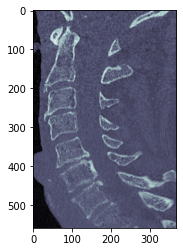

In [9]:
class SagittalDataset(Dataset):
    def __init__(self, df, image_dir, mask_dir, image_size=256, transform=None):
        super().__init__()

        self.df = df
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_size = image_size
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        s = self.df.iloc[idx]
        UID = s.name
        img = Image.open(os.path.join(self.image_dir, UID, f"{int(s.sagittal_index)}.jpeg"))
        img = TF.crop(img, s.top, s.left, s.bottom - s.top, s.right - s.left)

        mask = Image.open(os.path.join(self.mask_dir, UID, f"{int(s.sagittal_index)}.png"))
        mask = np.asarray(mask)
        # print(mask.shape)
        # print(self.image_size)
        row = np.clip(s.sagittal_label_y, a_min=0, a_max=(self.image_size-1))
        column = np.clip(s.sagittal_label_x, a_min=0, a_max=(self.image_size-1))
        # print(row, column)
        label = mask[row, column] / 256.
        if self.transform:
            img, mask, label = self.transform(img, mask, label)

        return img, mask, label

dataset = SagittalDataset(bbox_df, IMAGES_DIR, MASK_DIR)
img, mask, label = dataset[1]

print(label)
plt.imshow(img, cmap='bone')

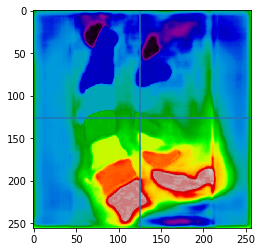

In [10]:
plt.imshow(mask, cmap="nipy_spectral")
plt.axhline(126)
plt.axvline(125)

In [11]:
label

0.49609375

### Transform

In [12]:
class DataTransform(nn.Module):
    def __init__(self, image_size, train=True):
        super().__init__()

        
        self.transform = T.Compose([
            T.Resize(image_size),
            T.RandomAutocontrast(),
            T.ToTensor(),
            T.Normalize(0.5, 0.5)
        ])
        
        # self.mask_transform = T.Normalize(0, 32)

        self.label_transform = T.ToTensor()

    def forward(self, x, mask, label):
        x = TF.center_crop(x, max(x.width, x.height))
        x = self.transform(x)

        # print(mask)
        mask = torch.tensor(mask, dtype=torch.float) / 256.
        # mask = mask
        # mask = self.mask_transform(mask)
        label = label / 0.125 - 1
        label = torch.tensor(np.round(label)).long()
        return x, mask, label
transform = DataTransform(image_size)

In [13]:
dataset = SagittalDataset(bbox_df, IMAGES_DIR, MASK_DIR, transform=transform)
img, mask, label = dataset[1]
print(label)
mask.max()

tensor(3)


tensor(0.8867)

In [14]:
def get_backbone():
    backbone = models.resnet50(pretrained=True)
    conv1_weight = backbone.conv1.weight
    conv1_weight = conv1_weight.mean(dim=1).unsqueeze(1)

    backbone.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=1, padding='same', bias=False)
    backbone.conv1.weight = nn.Parameter(conv1_weight, requires_grad=True)

    return nn.ModuleList([
        nn.Sequential(
            backbone.conv1,
            backbone.bn1,
            backbone.relu,
            backbone.maxpool),
        nn.Sequential(
            backbone.layer1,
            backbone.layer2,
        ),
        backbone.layer3,
        backbone.layer4
    ]), [1, 64, 512, 1024, 2048]

# backbone, channels = get_backbone()
# print(backbone)

In [15]:
def print_list_shape(list):
    for i, l in enumerate(list):
        print(f"{i} {l.shape}")

In [16]:
def check_list_nan(list, name=None):
    print("check_list_nan {}".format(name))
    for i, item in enumerate(list):
        print(f"{i} {torch.isnan(item).any()}")

In [17]:
class ClassificationModel(nn.Module):
    def __init__(self, backbone, channels, deep=4):
        super().__init__()

        self.backbone = backbone
        self.deep = deep
        self.channels = channels

        self.dw = nn.Parameter(torch.tensor(20.0, dtype=torch.float), requires_grad=False)
        self.register_buffer('mf', ((torch.arange(7) + 1) * 0.125).reshape(7, 1, 1))
        self.init_layers()

    def init_layers(self):
        self.parallel_modules_1 = self.make_parallel_modules()
        self.parallel_modules_2 = self.make_parallel_modules()
        self.downsampling_modules = self.make_downsampling_modules()
        self.mask_modules = self.make_mask_modules()
        self.classification_modules = self.make_classification_modules()

    def make_parallel_modules(self):
        parallel_modules = nn.ModuleList()

        for channel in self.channels:
            module = nn.Conv2d(channel, channel, kernel_size=1, padding='same')
            parallel_modules.append(module)

        return parallel_modules

    def make_mask_modules(self):
        mask_modules = nn.ModuleList()

        for i in range(self.deep):
            module = nn.Sequential(
                # nn.Conv2d(self.channels[i], self.channels[i+1], kernel_size=3, stride=2, padding=1),
                # nn.Sigmoid()
                nn.MaxPool2d(3, stride=2, padding=1)
            )
            mask_modules.append(module)

        return mask_modules

    def make_downsampling_modules(self):
        downsampling_modules = nn.ModuleList()

        for i in range(self.deep):
            module = nn.Sequential(
                nn.ReLU(),
                nn.Conv2d(self.channels[i], self.channels[i+1], kernel_size=3, stride=2, padding=1),
            )
            downsampling_modules.append(module)

        return downsampling_modules

    def make_classification_modules(self):
        return nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(self.channels[-1], self.channels[-1], kernel_size=3, padding='same'),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(self.channels[-1] * 16 * 16, 1)
        )

    def forward_recursive(self, x, modules):
        result = []
        out = x
        for module in modules:
            out = module(out)
            result.append(out)

        return result

    def forward_parallel(self, inputs, modules):
        result = []
        for input, module in zip(inputs, modules):
            out = module(input)
            result.append(out)

        return result

    def apply_mask(self, inputs, masks):
        result = []

        for input, mask in zip(inputs, masks):
            out = input * mask
            result.append(out)

        return result

    def repeat_mask(self, mask):
        N, H, W = mask.shape
        mask[mask == 0] = -torch.inf

        mask = (mask.unsqueeze(1) - self.mf) ** 2
        mask = torch.exp(-self.dw * mask)  # N, 7, H, W
        mask = mask.reshape(-1, 1, H, W)
        return mask

    def forward_downsampling(self, features, modules):
        out = features[0]
        for i, module in enumerate(modules):
            out = module(out) + features[i + 1]

        return out

    def forward(self, x, mask):
        backbone_features = self.forward_recursive(x, self.backbone)
        # check_list_nan(backbone_features, "backbone_features")

        mask = (mask / 0.125).round() * 0.125
        mask = self.repeat_mask(mask)   # 14, 1, 256, 256
        mask_features = self.forward_recursive(mask, self.mask_modules)

        # check_list_nan(mask_features, "mask_features")

        parallel_features_1 = self.forward_parallel([x] + backbone_features, self.parallel_modules_1)
        # 여기서 뻥튀기를 시킨다.
        parallel_features_1 = [feature.repeat_interleave(7, dim=0) for feature in parallel_features_1]

        # check_list_nan(parallel_features_1)

        masked_features = self.apply_mask(parallel_features_1, [mask] + mask_features)

        # check_list_nan(masked_features)
        out = self.forward_parallel(masked_features, self.parallel_modules_2)

        # check_list_nan(out)
        out = self.forward_downsampling(out, self.downsampling_modules)
        out = self.classification_modules(out)

        return out


# model = ClassificationModel(backbone, channels).to(device)
#
# total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# print(total_params)

# input = torch.randn(2, 1, 256, 256).to(device)
# mask = torch.randn(2, 256, 256).to(device)
# logits = model(input, mask)
# logits.shape

### Dataloader

In [18]:
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=min(16, batch_size))

### Loss function

In [19]:
def loss_fn(logits, y, pos_weight=torch.tensor(1)):
    labels = F.one_hot(y, num_classes=7).reshape(-1, 1).float()

    loss = F.binary_cross_entropy_with_logits(logits, labels, pos_weight=pos_weight)
    return loss


In [20]:
def denormalize_img(x):
    img = x.detach().cpu().numpy()
    img = (img * 0.5) + 0.5
    img = img.transpose(0, 2, 3, 1)
    return img

In [21]:
# img = denormalize_img(x)
# plt.imshow(img[0], cmap='bone')

In [22]:
backbone, channels = get_backbone()
model = ClassificationModel(backbone, channels).to(device)
# optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)

# total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# total_params


In [23]:
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
scaler = torch.cuda.amp.GradScaler(enabled=(device == 'cuda'))

In [24]:
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10, 15, 20], gamma=0.5)


In [25]:
pos_weight = torch.tensor(pos_weight)

### train_one_epoch

In [26]:
def train_one_epoch(e, model, dataloader):
    model.train()
    train_iter = tqdm(dataloader)
    losses = []
    epoch_iteration = len(dataloader)

    for i, (x, mask, y) in enumerate(train_iter):
        x = x.to(device)
        mask = mask.to(device)
        y = y.to(device)

        with torch.cuda.amp.autocast(device == 'cuda'):
            logits = model(x, mask)
            loss = loss_fn(logits, y, pos_weight=pos_weight)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.)
        scaler.step(optimizer)
        scaler.update()

        train_iter.set_description(f"t {e} loss {loss.item():.4f}")

        losses.append(loss.item())

        if wandb.run is not None:
            lr_logs = {f"last_lr_{i}": float(v) for i, v in enumerate(scheduler.get_last_lr())}
            wandb.log({
                'train_loss': loss.item(),
                'epoch': e,
                'train_iteration': i + e * epoch_iteration,
                **lr_logs,
            })

        if i % 100 == 0:
            with torch.no_grad():
                infer_bad_sample(wandb_log=True)
            model.train()

    return np.mean(losses)

In [27]:
boundary_df = pd.read_csv('infer_sagittal_position.csv').set_index('UID')
boundary_df.head()

,direction,sagittal_index,bottom,right,top,left,z_spacing,pixel_spacing,aspect,width,height,coronal_left,coronal_top,coronal_right,coronal_bottom,sagittal_left,sagittal_top,sagittal_right,sagittal_bottom
UID,,,,,,,,,,,,,,,,,,,
1.2.826.0.1.3680043.10001,2,88,590,377,98,49,0.625,0.253906,2.461541,512,659,74,54,185,213,58,54,164,213
1.2.826.0.1.3680043.10001,2,89,590,377,98,49,0.625,0.253906,2.461541,512,659,74,54,185,213,58,54,164,213
1.2.826.0.1.3680043.10001,2,90,590,377,98,49,0.625,0.253906,2.461541,512,659,74,54,185,213,58,54,164,213
1.2.826.0.1.3680043.10001,2,91,590,377,98,49,0.625,0.253906,2.461541,512,659,74,54,185,213,58,54,164,213
1.2.826.0.1.3680043.10001,2,92,590,377,98,49,0.625,0.253906,2.461541,512,659,74,54,185,213,58,54,164,213


In [28]:
boundary_df.loc["1.2.826.0.1.3680043.10016", ['left','top','right','bottom']].iloc[0].values

array([ 37,  98, 396, 601])

In [29]:
def get_inference_input(UID, index):
    
    left, top, right, bottom = boundary_df.loc[UID, ['left','top','right','bottom']].iloc[0].values
    # print([left, top, right, bottom])
    org_img = Image.open(os.path.join(IMAGES_DIR, UID, f"{int(index)}.jpeg"))
    x = TF.crop(org_img, top, left, bottom-top, right-left)
    
    transform = T.Compose([
            T.Resize(image_size),
            T.RandomAutocontrast(),
            T.ToTensor(),
            T.Normalize(0.5, 0.5)
        ])
    
    x = TF.center_crop(x, max(x.width, x.height))
    x = transform(x)

    mask = Image.open(os.path.join(MASK_DIR, UID, f"{int(index)}.png"))
    mask = np.asarray(mask)
    # print(mask)
    mask = torch.tensor(mask, dtype=torch.float) / 256.
    
    return x, mask

x, mask = get_inference_input("1.2.826.0.1.3680043.10016", 314)
mask.shape

torch.Size([256, 256])

In [30]:
def infer_sample(model,  UIDs, indices, labels, wandb_log=False):
    model.eval()

    x_list = []
    mask_list = []
    for UID, index in zip(UIDs, indices):
        x, mask = get_inference_input(UID, index)
        x_list.append(x)
        mask_list.append(mask)
        
    x = torch.stack(x_list)
    mask = torch.stack(mask_list)

    x = x.to(device)
    mask = mask.to(device)
    labels = torch.tensor(labels).to(device)
    
    logits = model(x, mask)
    loss = loss_fn(logits, labels)
    prob = logits.sigmoid().reshape(-1, 7)
    
    # print(prob)
    # print(loss.item())
    if wandb_log is True and wandb.run is not None:
        wandb.log({
            'img_pred_prob' : prob.reshape(-1, 7),
            'img_pred_loss' : loss.item(), 
        })
    if wandb_log is False:
        
        
    
        img = denormalize_img(x)
        _, axs = plt.subplots(1, 2, figsize=(12, 12))
        axs[0].imshow(img[0], cmap='bone')
        axs[1].imshow(mask[0].squeeze().cpu().numpy(), cmap='nipy_spectral')
        # plt.imshow(img[0], cmap='bone')
        # plt.imshow(mask[0].squeeze().cpu().numpy(), cmap='nipy_spectral', alpha=0.2)

@torch.no_grad()
def infer_bad_sample(wandb_log=False):

    sample_UIDs = ["1.2.826.0.1.3680043.1010", "1.2.826.0.1.3680043.10204","1.2.826.0.1.3680043.10261", "1.2.826.0.1.3680043.7195"]
    indices = [199,248,259,270]
    labels = [5,1,1,1]
    infer_sample(model, sample_UIDs, indices, labels, wandb_log=wandb_log)

infer_bad_sample(wandb_log=True)

In [31]:
epoch = 0

In [32]:
epochs = 5

for e in range(epochs):

    train_loss = train_one_epoch(epoch, model, train_loader)
    
    with torch.no_grad():
        infer_bad_sample(wandb_log=True)
    
    epoch += 1

t 3 loss 0.1657:  40%|████      | 181/451 [01:38<02:27,  1.84it/s]


KeyboardInterrupt: 

In [ ]:
state = {
    "model": model.state_dict(),
    "optimizer": optimizer.state_dict(),
    "scheduler": scheduler.state_dict(),
    "epoch": epoch,
}
torch.save(state, f'checkpoint/{wandb.run.name}-epoch-{epoch}.pth')